In [ ]:
%%capture
!pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report

from category_encoders.leave_one_out import LeaveOneOutEncoder

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

In [ ]:
plt.rcParams["figure.figsize"] = (12, 8)

## Предпосылки

**Гиперпараметры** - параметры алгоритмов, значения которых устанавливаются перед запуском процесса обучения.

**Параметры** напротив вычисляются во время обучения.

Гиперпараметры оказывают существенное влияние на модель и итоговое качество, поэтому целесообразно подбирать их особым образом

## Подготовка данных

In [ ]:
data = pd.read_csv('imdb_top_1000.csv')
data['cast'] = data[['Star1', 'Star2', 'Star3', 'Star4']].agg(' '.join, axis=1)
data['all_text'] = data['Series_Title'] + ' ' + data['Overview'] + ' ' + data['cast']
data['Runtime'] = data['Runtime'].map(lambda x: x.split()[0]).astype(int)
data['Gross'] = data['Gross'].str.replace(',', '').astype(float)
data['Released_Year'] = pd.to_numeric(data['Released_Year'], errors='coerce')
data = pd.concat([data.drop(columns=['Genre']), data['Genre'].str.replace(' ', '').str.get_dummies(sep=",")], axis=1)
data = data.drop(columns=['Poster_Link', 'Series_Title', 'Overview', 'Star1', 'Star2', 'Star3', 'Star4'])
data.head(2)

,Released_Year,Certificate,Runtime,IMDB_Rating,Meta_score,Director,No_of_Votes,Gross,cast,all_text,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1994.0,A,142,9.3,80.0,Frank Darabont,2343110,28341469.0,Tim Robbins Morgan Freeman Bob Gunton William ...,The Shawshank Redemption Two imprisoned men bo...,...,0,0,0,0,0,0,0,0,0,0
1,1972.0,A,175,9.2,100.0,Francis Ford Coppola,1620367,134966411.0,Marlon Brando Al Pacino James Caan Diane Keaton,The Godfather An organized crime dynasty's agi...,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X, y = data.drop(columns='IMDB_Rating'), data['IMDB_Rating']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=77)

In [ ]:
categorical_preprocessing = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('target_encoder', LeaveOneOutEncoder()),
])

numeric_preprocessing = Pipeline([
     ('imputer', SimpleImputer(strategy='mean', fill_value=0)),
     ('scaler', StandardScaler())
])

text_preprocessing = Pipeline([
     ('tf-idf', TfidfVectorizer())
])

preprocessing = make_column_transformer(
     (text_preprocessing, 'all_text'),
     (numeric_preprocessing,  make_column_selector(dtype_include=np.number)),
     (categorical_preprocessing, ['Certificate', 'Director']),
)

In [ ]:
preprocessing

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('tf-idf',
                                                  TfidfVectorizer())]),
                                 'all_text'),
                                ('pipeline-2',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0)),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7cbaa6c29840>),
                                ('pipeline-3',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('target_encoder',
                                                  LeaveOneOutEncoder())]),
                                 ['Certificate', 'Director'])])

In [ ]:
print(preprocessing)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('tf-idf',
                                                  TfidfVectorizer())]),
                                 'all_text'),
                                ('pipeline-2',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0)),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7cbaa6c29840>),
                                ('pipeline-3',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('target_encoder',
                                      

In [ ]:
pipeline = Pipeline([
      ('preprocessor', preprocessing),
      ("model", Ridge(alpha=0))
])

## Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
model = pipeline.fit(X_train, y_train)
model.score(X_test, y_test)

0.3699570738626069

#### Оптимизация гиперпараметров

In [ ]:
print(preprocessing)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('tf-idf',
                                                  TfidfVectorizer())]),
                                 'all_text'),
                                ('pipeline-2',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0)),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x78f610f3bcd0>),
                                ('pipeline-3',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('target_encoder',
                                      

In [ ]:
param_grid = {
    'preprocessor__pipeline-1__tf-idf__ngram_range' : [(1, 1), (1, 2)],
    'preprocessor__pipeline-1__tf-idf__max_df' : [0.9, 1.0],
    'preprocessor__pipeline-2__imputer__strategy' : ['mean', 'median', 'constant'],
    'preprocessor__pipeline-2__scaler' : [StandardScaler(), RobustScaler()],
    'preprocessor__pipeline-3__imputer__strategy' : ['constant', 'most_frequent'],
    'model__alpha' : np.linspace(0, 1, 10)
}

In [ ]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=2,
    verbose=1,
)

In [ ]:
%%time

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
CPU times: user 29 s, sys: 1.78 s, total: 30.7 s
Wall time: 6min 50s


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('tf-idf',
                                                                                          TfidfVectorizer())]),
                                                                         'all_text'),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x78f610f3bcd0>),
                                                                        ('pipeli...
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                         'preprocessor__pipeline-1__tf-idf__max_df': [0.9, 1.0],
                         'preprocessor__pipeline-1__tf-idf__ngram_range': [(1,
                                                                            1),
                                                                           (1,
                                                                            2)],
                         'preprocessor__pipeline-2__imputer__strategy': ['mean',
                                                                         'median',
                                                                         'constant'],
                         'preprocessor__pipeline-2__scaler': [StandardScaler(),
                                                              RobustScaler()],
                         'preprocessor__pipeline-3__imputer__strategy': ['constant',
                                                                         'most_frequent']},
             verbose=1)

In [ ]:
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

model__alpha: 1.0
preprocessor__pipeline-1__tf-idf__max_df: 0.9
preprocessor__pipeline-1__tf-idf__ngram_range: (1, 1)
preprocessor__pipeline-2__imputer__strategy: median
preprocessor__pipeline-2__scaler: RobustScaler()
preprocessor__pipeline-3__imputer__strategy: constant


In [ ]:
grid_search.best_estimator_.score(X_test, y_test)

0.40558646071434545

##  Randomized Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=50,
    random_state=2024,
    n_jobs=2,
    verbose=1,
)

In [ ]:
%%time

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: user 3.12 s, sys: 152 ms, total: 3.28 s
Wall time: 41.2 s


RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('tf-idf',
                                                                                                TfidfVectorizer())]),
                                                                               'all_text'),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value=0)),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x78f610f3bcd0>),
                                                                              ('...
                                        'preprocessor__pipeline-1__tf-idf__max_df': [0.9,
                                                                                     1.0],
                                        'preprocessor__pipeline-1__tf-idf__ngram_range': [(1,
                                                                                           1),
                                                                                          (1,
                                                                                           2)],
                                        'preprocessor__pipeline-2__imputer__strategy': ['mean',
                                                                                        'median',
                                                                                        'constant'],
                                        'preprocessor__pipeline-2__scaler': [StandardScaler(),
                                                                             RobustScaler()],
                                        'preprocessor__pipeline-3__imputer__strategy': ['constant',
                                                                                        'most_frequent']},
                   random_state=2024, verbose=1)

In [ ]:
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

model__alpha: 0.6666666666666666
preprocessor__pipeline-1__tf-idf__max_df: 1.0
preprocessor__pipeline-1__tf-idf__ngram_range: (1, 1)
preprocessor__pipeline-2__imputer__strategy: median
preprocessor__pipeline-2__scaler: RobustScaler()
preprocessor__pipeline-3__imputer__strategy: constant


In [ ]:
grid_search.best_estimator_.score(X_test, y_test)

0.40558646071434545

## Halving Grid Search

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

In [ ]:
%%time

X, y = make_classification(n_samples=400, n_features=12, random_state=0)

clf = RandomForestClassifier(n_estimators=20, random_state=0)

param_dist = {
    "max_depth": [3, None],
    "max_features": np.arange(1, 6),
    "min_samples_split": np.arange(2, 11),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
}

rsh = HalvingRandomSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    factor=2,
    random_state=0,
)
rsh.fit(X, y)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


CPU times: user 7.32 s, sys: 59.6 ms, total: 7.37 s
Wall time: 7.47 s


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


HalvingRandomSearchCV(estimator=RandomForestClassifier(n_estimators=20,
                                                       random_state=0),
                      factor=2,
                      param_distributions={'bootstrap': [True, False],
                                           'criterion': ['gini', 'entropy'],
                                           'max_depth': [3, None],
                                           'max_features': array([1, 2, 3, 4, 5]),
                                           'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
                      random_state=0)

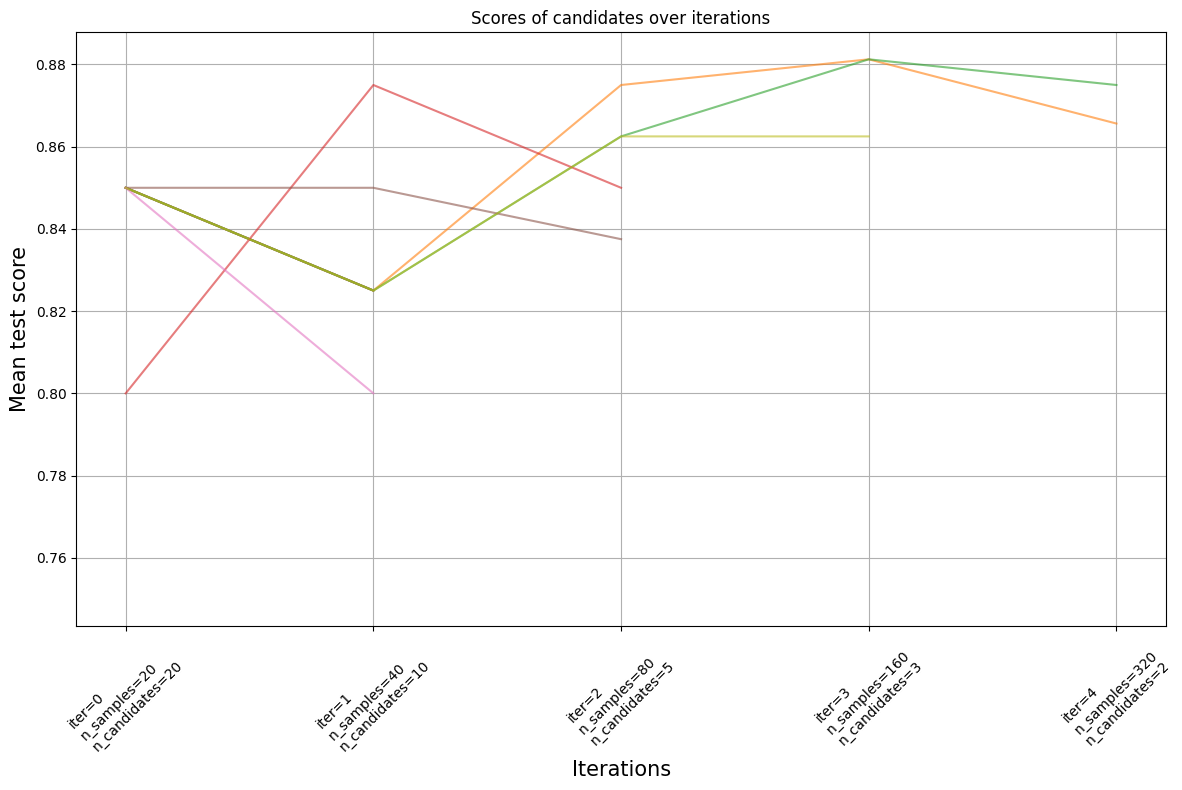

In [ ]:
results = pd.DataFrame(rsh.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter",
    columns="params_str",
     values="mean_test_score",
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={rsh.n_resources_[i]}\nn_candidates={rsh.n_candidates_[i]}"
    for i in range(rsh.n_iterations_)
]

ax.set_xticks(range(rsh.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("Mean test score", fontsize=15)
ax.set_xlabel("Iterations", fontsize=15)
plt.tight_layout()
plt.grid()
plt.show()

## Оценка статистической значимости результатов

In [ ]:
from sklearn.model_selection import RepeatedKFold

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

In [ ]:
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=50,
    random_state=2024,
    n_jobs=2,
    verbose=1,
    cv=cv,
)

In [ ]:
%%time

random_search.fit(X_train, y_train)

Fitting 100 folds for each of 50 candidates, totalling 5000 fits
CPU times: user 36.2 s, sys: 2.89 s, total: 39.1 s
Wall time: 13min 35s


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=10, random_state=0),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('tf-idf',
                                                                                                TfidfVectorizer())]),
                                                                               'all_text'),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value=0)),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_t...
                                        'preprocessor__pipeline-1__tf-idf__max_df': [0.9,
                                                                                     1.0],
                                        'preprocessor__pipeline-1__tf-idf__ngram_range': [(1,
                                                                                           1),
                                                                                          (1,
                                                                                           2)],
                                        'preprocessor__pipeline-2__imputer__strategy': ['mean',
                                                                                        'median',
                                                                                        'constant'],
                                        'preprocessor__pipeline-2__scaler': [StandardScaler(),
                                                                             RobustScaler()],
                                        'preprocessor__pipeline-3__imputer__strategy': ['constant',
                                                                                        'most_frequent']},
                   random_state=2024, verbose=1)

In [ ]:
results_df = pd.DataFrame(random_search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])

with pd.option_context('display.max_colwidth', 400):
    display(results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]].head())

,params,rank_test_score,mean_test_score,std_test_score
1,"{'preprocessor__pipeline-3__imputer__strategy': 'constant', 'preprocessor__pipeline-2__scaler': RobustScaler(), 'preprocessor__pipeline-2__imputer__strategy': 'median', 'preprocessor__pipeline-1__tf-idf__ngram_range': (1, 1), 'preprocessor__pipeline-1__tf-idf__max_df': 1.0, 'model__alpha': 0.6666666666666666}",1,0.466550,0.115636
37,"{'preprocessor__pipeline-3__imputer__strategy': 'most_frequent', 'preprocessor__pipeline-2__scaler': RobustScaler(), 'preprocessor__pipeline-2__imputer__strategy': 'median', 'preprocessor__pipeline-1__tf-idf__ngram_range': (1, 2), 'preprocessor__pipeline-1__tf-idf__max_df': 1.0, 'model__alpha': 0.4444444444444444}",2,0.466186,0.115288
7,"{'preprocessor__pipeline-3__imputer__strategy': 'most_frequent', 'preprocessor__pipeline-2__scaler': RobustScaler(), 'preprocessor__pipeline-2__imputer__strategy': 'median', 'preprocessor__pipeline-1__tf-idf__ngram_range': (1, 2), 'preprocessor__pipeline-1__tf-idf__max_df': 0.9, 'model__alpha': 0.8888888888888888}",3,0.465789,0.115716
39,"{'preprocessor__pipeline-3__imputer__strategy': 'constant', 'preprocessor__pipeline-2__scaler': RobustScaler(), 'preprocessor__pipeline-2__imputer__strategy': 'median', 'preprocessor__pipeline-1__tf-idf__ngram_range': (1, 2), 'preprocessor__pipeline-1__tf-idf__max_df': 1.0, 'model__alpha': 0.8888888888888888}",4,0.465746,0.115680
41,"{'preprocessor__pipeline-3__imputer__strategy': 'most_frequent', 'preprocessor__pipeline-2__scaler': StandardScaler(), 'preprocessor__pipeline-2__imputer__strategy': 'median', 'preprocessor__pipeline-1__tf-idf__ngram_range': (1, 1), 'preprocessor__pipeline-1__tf-idf__max_df': 1.0, 'model__alpha': 0.7777777777777777}",5,0.465562,0.115957


Для оценки статзначимости результатов можно провести статтест, однако экспериментальные оценки моделей не являются независимыми, так как все модели оцениваются на тех же фолдах, что увеличивает корреляцию между их метриками

[Курс прикладной статистики от Авито](https://avito.tech/education/statistics)

In [ ]:
model_scores = results_df.filter(regex=r"split\d*_test_score")
display(model_scores.corr().style.map(lambda x: 'background-color : red' if (x > 0.95) and x != 1 else ''))

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,split50_test_score,split51_test_score,split52_test_score,split53_test_score,split54_test_score,split55_test_score,split56_test_score,split57_test_score,split58_test_score,split59_test_score,split60_test_score,split61_test_score,split62_test_score,split63_test_score,split64_test_score,split65_test_score,split66_test_score,split67_test_score,split68_test_score,split69_test_score,split70_test_score,split71_test_score,split72_test_score,split73_test_score,split74_test_score,split75_test_score,split76_test_score,split77_test_score,split78_test_score,split79_test_score,split80_test_score,split81_test_score,split82_test_score,split83_test_score,split84_test_score,split85_test_score,split86_test_score,split87_test_score,split88_test_score,split89_test_score,split90_test_score,split91_test_score,split92_test_score,split93_test_score,split94_test_score,split95_test_score,split96_test_score,split97_test_score,split98_test_score,split99_test_score
split0_test_score,1.000000,-0.430491,-0.069392,-0.497456,0.088957,-0.736638,0.298264,0.354786,0.660980,-0.221658,0.484156,0.230646,-0.737605,0.633507,0.186361,-0.571458,0.354289,-0.755859,-0.127638,0.120093,-0.379290,-0.297482,0.210871,-0.795333,-0.533267,0.356337,0.353895,0.022165,0.345706,0.399440,0.309048,0.060010,-0.743263,0.007136,0.464079,-0.284985,-0.476610,0.272102,0.468379,0.357717,0.751771,0.768074,-0.112869,0.272150,0.373982,-0.108692,0.351591,0.064295,0.411216,-0.479411,0.692834,0.743088,-0.585485,0.152809,0.362816,0.080880,0.038342,0.260457,0.540265,-0.109247,0.318502,0.368588,0.187848,0.352034,-0.451130,0.240165,-0.301341,-0.836664,0.335991,0.240331,0.360259,0.611207,0.044527,0.498937,0.481535,-0.815845,0.138575,-0.257713,-0.607248,-0.479248,-0.831167,-0.158751,0.338390,0.360930,0.038015,-0.766753,-0.298584,0.012780,0.698108,0.082221,0.246025,0.569497,-0.635940,0.488438,0.734399,-0.700890,0.347511,0.147477,-0.079518,0.730224
split1_test_score,-0.430491,1.000000,-0.035717,0.365084,-0.132661,0.708798,-0.320946,-0.443587,-0.016130,0.040749,-0.619192,-0.298621,0.688057,-0.349950,-0.238875,0.492856,-0.438471,0.834571,0.173603,0.567723,0.806899,0.725413,-0.368202,0.804474,0.761178,-0.325142,-0.438493,0.679814,-0.248062,-0.314379,-0.185715,-0.094708,0.768404,0.205092,-0.349849,0.139146,0.947928,-0.365854,-0.471883,-0.437776,-0.108686,-0.651576,0.237479,-0.304164,0.484475,0.497431,-0.437712,-0.214282,-0.317770,0.203207,-0.583468,-0.173866,0.614635,0.019878,-0.437094,0.700980,-0.099265,-0.284905,-0.419395,-0.121977,0.434993,-0.232621,0.345504,-0.440018,0.975572,0.044022,0.844198,0.585039,-0.562160,-0.294000,-0.440057,0.114946,0.008974,-0.489621,-0.339367,0.682606,-0.039323,0.779500,0.287528,0.697044,0.647548,-0.050728,0.044695,-0.437619,-0.167890,0.720508,0.223742,0.401696,-0.455047,-0.269128,-0.353648,0.158333,0.523327,-0.299079,-0.476273,0.581863,-0.437902,-0.160972,0.092557,-0.046497
split2_test_score,-0.069392,-0.035717,1.000000,0.806871,0.981238,0.441483,0.910562,0.867707,-0.715775,0.863284,0.678957,0.935817,-0.318378,0.703891,0.957909,0.716019,0.869340,-0.273646

Если предоположить независимость в выборках, будет недооцениваться дисперсия в статтестах, увеличивая количество ложноположительных ошибок. В этих случаях можно применить стат тесты с поправкой на дисперсию.

[Cкорректированный t-test Надо и Бенжио - Inference for the Generalization Error](https://www.researchgate.net/publication/227049463_Inference_for_the_Generalization_Error)

In [ ]:
import numpy as np
from scipy.stats import t


def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes right-tailed paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

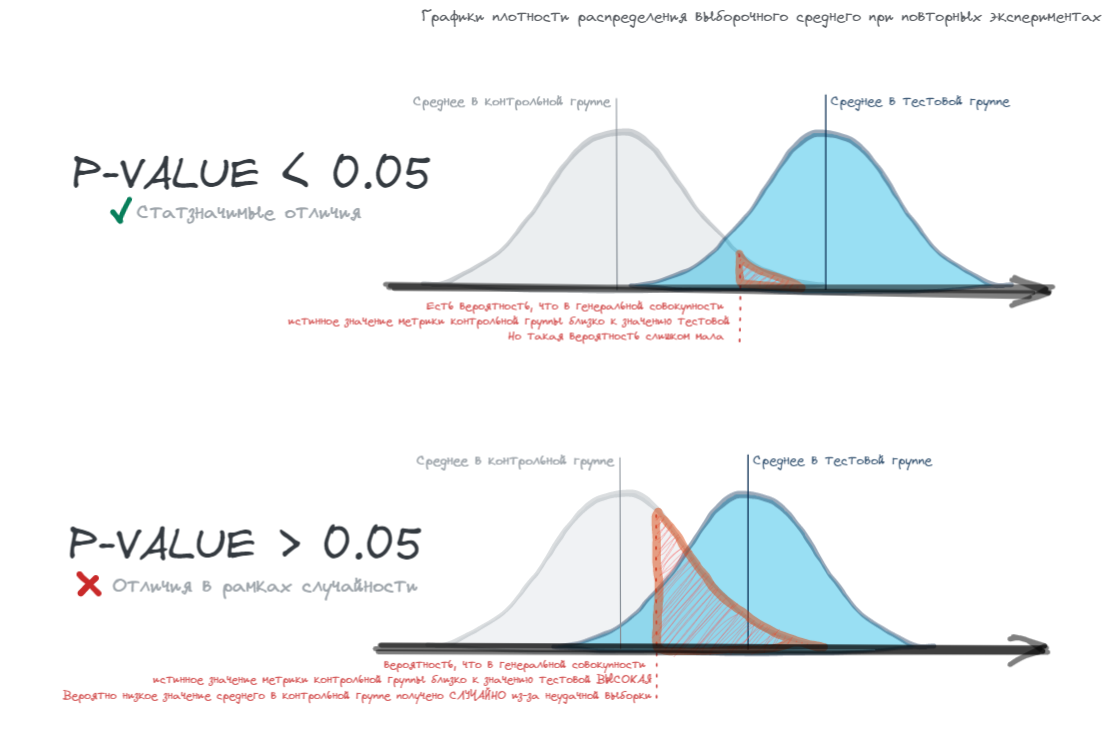

In [ ]:
def run_corrected_test(model_1_scores, model_2_scores):
  differences = model_1_scores - model_2_scores

  n = differences.shape[0]
  df = n - 1
  n_train = len(list(cv.split(X_train, y_train))[0][0])
  n_test = len(list(cv.split(X_train, y_train))[0][1])

  t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
  print(f"Corrected t-value: {t_stat:.3f}\nCorrected p-value: {p_val:.3f}")

In [ ]:
model_1_scores = model_scores.iloc[0].values  # scores of the best model
model_2_scores = model_scores.iloc[1].values  # scores of the second-best model

run_corrected_test(model_1_scores, model_2_scores)

Corrected t-value: 0.076
Corrected p-value: 0.470


In [ ]:
model_1_scores = model_scores.iloc[0].values
model_2_scores = model_scores.iloc[20].values

run_corrected_test(model_1_scores, model_2_scores)

Corrected t-value: 2.918
Corrected p-value: 0.002


In [ ]:
def run_uncorrected_test(model_1_scores, model_2_scores):
  differences = model_1_scores - model_2_scores
  n = differences.shape[0]
  df = n - 1

  t_stat_uncorrected = np.mean(differences) / np.sqrt(np.var(differences, ddof=1) / n)
  p_val_uncorrected = t.sf(np.abs(t_stat_uncorrected), df)

  print(
      f"Uncorrected t-value: {t_stat_uncorrected:.3f}\n"
      f"Uncorrected p-value: {p_val_uncorrected:.3f}"
  )

In [ ]:
model_1_scores = model_scores.iloc[0].values
model_2_scores = model_scores.iloc[1].values

run_uncorrected_test(model_1_scores, model_2_scores)

Uncorrected t-value: 0.265
Uncorrected p-value: 0.396
